In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout
from mpl_toolkits.mplot3d import Axes3D
from time import time
np.random.seed(0)

In [59]:
class SOMNetwork():
    def __init__(self, x,y, dim=10, sigma=None, learning_rate=0.1, tau1=1000, tau2=1000, dtype=tf.float32,accuracy = 0.001,init_map=None):
        np.random.seed(0)
        self.dtype = dtype
        self._X = x
        self._Y = y
        if init_map==None:
            self._data = np.random.rand(x,y,dim)
        else: 
            self._data = DATA.reshape(30,30,3)
        self._map_weights = tf.Variable(self._data,dtype=self.dtype, name='weights')
        self.dim = tf.constant(dim, dtype=tf.int64)
        self._learning_rate = tf.constant(learning_rate, dtype=self.dtype, name='learning_rate')
        self._sigma = tf.constant(sigma, dtype=self.dtype, name='sigma')
        self._tau1 = tf.constant(tau1, dtype=self.dtype, name='tau_learn_rate')
        self._tau2 = tf.constant(tau2, dtype=self.dtype, name='tau_sigma')
        self._accuracy = accuracy
        self._input = tf.placeholder(shape=[dim], dtype=self.dtype, name='input')
        self._num_iter = tf.placeholder(dtype=self.dtype, name='iteration')
        self.positions = tf.where(tf.fill([dim, dim], True)) #полезно
        self._distance_map = tf.constant(self.Get_Distances(self._X, self._Y),dtype='float32') #[0,1,2,3,2,1]
        self.SOM_MAP = 1   #сохраняем карту сюда после сессии
        
    def change_params(self,sigma=6, learning_rate=0.1, tau1=1000, tau2=1000, init_map=None):
        self._sigma = tf.constant(sigma, dtype=self.dtype, name='sigma')
        self._learning_rate = tf.constant(learning_rate, dtype=self.dtype, name='learning_rate')
        self._tau1 = tf.constant(tau1, dtype=self.dtype, name='tau_learn_rate')
        self._tau2 = tf.constant(tau2, dtype=self.dtype, name='tau_sigma')
        self._data = init_map
        self._map_weights = tf.Variable(self._data,dtype=self.dtype, name='weights')
        
    def _train(self):
        with tf.name_scope('cooperation') as scope:
            #Calculating BMU
            bmu_location = self._won_neuron()
            
            _current_learning_rate = tf.maximum(self._learning_rate*tf.exp(-self._num_iter/self._tau1), 0.1)
            _current_sigma = tf.maximum(self._sigma*tf.exp(-self._num_iter/self._tau2), 0.1)
            
            bmu_distance = tf.roll(self._distance_map,shift=bmu_location, axis=[0,1])
            neighbourhood_func = tf.exp(-bmu_distance/(2*_current_sigma**2))
            learning_rate_matrix = _current_learning_rate* neighbourhood_func
            delta = tf.transpose(tf.transpose(self._input-self._map_weights)*tf.transpose(learning_rate_matrix))
            new_weights = tf.add(self._map_weights, delta)
            training_op = tf.assign(self._map_weights, new_weights)
            
        return training_op
    
    def _won_neuron(self):
        #M = self._input - self._map_weights
        #distance = tf.norm(self._input - self._map_weights,axis=-1)
        distance = tf.sqrt(tf.reduce_sum(tf.square(self._input - self._map_weights), axis=-1))
        bmu=tf.argmin(tf.reshape(distance, [-1]))
        #bmu_location = self.positions[bmu]
        bmu_location = tf.unravel_index(bmu, [self._X,self._Y])
        return bmu_location
    
    def training(self, data, n_iters,Verbose=False):
        #summary_writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())
        #summary_op = tf.summary.scalar('Functional_Z', self.FUNCTIONAL_Z())
        init = tf.global_variables_initializer()
        _data = tf.constant(data,dtype=self.dtype, name='data')
        _training = self._train()
        _functional = self.FUNCTIONAL_Z()
        data_len = len(data)
        temp_funq = 0
        
        with tf.Session() as sess:
            init.run()
            for i in range(n_iters):
                n_item = np.random.randint(data_len)
                sess.run(_training, feed_dict={self._input: data[n_item], self._num_iter:i})
                if i % 50 == 0:
                    #summary_writer.add_summary(sess.run(summary_op), i)
                    new_funq=sess.run(_functional)
                    if abs(temp_funq-new_funq)<self._accuracy: break
                    temp_funq = np.copy(new_funq)
                if Verbose:
                    _to_print = f'\r Iters = {i}, funq = {new_funq}'
                    stdout.write(_to_print)
            self.SOM_MAP = SOM._map_weights.eval()
        sess.close()
        return i, new_funq
            
    
    def check_for_nodes(self,data):
        def WIN_NEURON(vect):
            distances=np.linalg.norm(self.SOM_MAP-vect,axis=-1)
            index=np.argmin(distances)
            return index
        #for i in range(len(data)):
        for vect in data:
            a=WIN_NEURON(vect)
            print(a)
    
    def Get_Distances(self,y,x):
        def ring_closure(A):
            if A==1: return [0]
            a=np.arange(A)
            max_val = int(len(a)/2)
            max_ind=np.argwhere(a==max_val)[0,0]
            if len(a)%2==0:
                b=np.arange(1,a[max_ind])[::-1]
            else:
                b=np.arange(1,a[max_ind+1])[::-1]
            a[max_ind+1:]=b
            return a
        yv=ring_closure(y)
        xv=ring_closure(x)
        XV, YV = np.meshgrid(xv, yv)
        #res = np.stack((YV,XV), axis=-1)
        res = np.sqrt(XV**2+YV**2)
        return res
    
    def ring_closure(self,A):
        if A==1: return [0]
        a=np.arange(A)
        max_val = int(len(a)/2)
        max_ind=np.argwhere(a==max_val)[0,0]
        if len(a)%2==0:
            b=np.arange(1,a[max_ind])[::-1]
        else:
            b=np.arange(1,a[max_ind+1])[::-1]
        a[max_ind+1:]=b
        return a
    
    def FUNCTIONAL_Z(self):
        #ATTENTION! Working only for 2D maps
        #Functional_Z = 0
        B=tf.roll(self._map_weights, shift=1, axis=0)
        F1 = tf.reduce_sum(tf.norm(tf.subtract(self._map_weights,B),axis=-1))
        B=tf.roll(self._map_weights, shift=1, axis=1)
        F2 = tf.reduce_sum(tf.norm(tf.subtract(self._map_weights,B),axis=-1))
        return F1+F2
    
    
    def func_for_Q(self):
        bmu = self._won_neuron()
        dist = tf.norm(self._input-self._map_weights[bmu], axis=0)
        return dist
    
    def FUNCTIONAL_Q(self):
        FUNC = tf.Variable(0)
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            init.run()
            for i in range(len(DATA)):
                FUNC+=sess.run(func_for_Q, feed_dict = {self._input:DATA[i]})

In [50]:
#DATA = np.load('cube100x100_60.npy')
#DATA = np.load('cube100x100_30.npy')
#DATA = np.load('cube100x100_30x30_2D.npy')
DATA = np.load('data_circle_30x30_2D.npy')
#print(DATA[111])

In [12]:
def Functional_Z(a):
    F1 = np.linalg.norm(a-np.roll(a,1,axis=0), axis=-1).sum()
    F2 = np.linalg.norm(a-np.roll(a,1,axis=1), axis=-1).sum()
    return F1+F2
Functional_Z(DATA.reshape(30,30,3))

307.493861325969

In [61]:
#SOM = SOMNetwork(x=30,y=30,dim=len(DATA[0]),sigma=2,learning_rate=1,tau1=1000,tau2=1000,dtype=tf.float32)  ну кое как
SOM = SOMNetwork(x=30,y=30,dim=len(DATA[0]),sigma=2,learning_rate=1,tau1=3000,tau2=3000,dtype=tf.float32)
#SOM.test()
time_start=time()
iters, funq = SOM.training(DATA, 40000, Verbose=True)
print('time taken: ',time()-time_start)
print(f'took{iters} iters, funq {funq}')

#SOM.look_for_nodes(DATA)
SOM_MAP = SOM.SOM_MAP

 Iters = 12999, funq = 289.47052001953125time taken:  12.802255868911743
took13000 iters, funq 289.47027587890625


In [63]:
SOM.change_params(sigma=1,learning_rate=1,tau1=2000,tau2=1000, init_map=DATA.reshape(30,30,3))
time_start=time()
iters, funq = SOM.training(DATA, 40000, Verbose=True)
print()
print('time taken: ',time()-time_start)
print(f'took{iters} iters, funq {funq}')
SOM_MAP = SOM.SOM_MAP

 Iters = 2399, funq = 280.78979492187595
time taken:  2.5320796966552734
took2400 iters, funq 280.7889099121094


In [24]:
#DATA1 = DATA.reshape(30,30,3)
DATA1 = SOM_MAP

In [43]:
DATA1 = SOM_MAP
@interact(i=(0,29,1))
def print_circle(i=0):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121, projection='3d')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    xs = SOM_MAP[:,i, 0]
    ys = SOM_MAP[:,i, 1]
    zs = SOM_MAP[:,i, 2]
    ax.plot(xs, ys, zs, marker='^')
    
    xs = SOM_MAP[i,:, 0]
    ys = SOM_MAP[i,:, 1]
    zs = SOM_MAP[i,:, 2]

    ax.plot(xs, ys, zs, marker='^')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax1 = fig.add_subplot(122, projection='3d')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    #plt.zlim(-1, 1)
    DD=SOM_MAP.reshape(-1,3)
    xs = DD[:, 0]
    ys = DD[:, 1]
    zs = DD[:, 2]
    ax1.scatter(xs, ys, zs, c='b', marker='^')
    #ax.plot(xs, ys, zs, marker='^')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [44]:
import numpy
from mayavi.mlab import *

def test_points3d():
    dd=DATA1.reshape(-1,3)
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]

    return points3d(x, y, z, colormap="copper", scale_factor=.1)

test_points3d()
show()

In [103]:
@interact(i=(0,29,1))
def print_circle(i=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    #plt.zlim(-1, 1)
    xs = DATA1[i,:, 0]
    ys = DATA1[i,:, 1]
    zs = DATA1[i,:, 2]
    #ax.scatter(xs, ys, zs, c='b', marker='^')
    ax.plot(xs, ys, zs, marker='^')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [69]:
def _iterator():
    for learn_rate in [1]:
        for sigma in np.linspace(1, 30, 6):
            for tau1 in np.linspace(100, 5000, 10):
                for tau2 in np.linspace(100, 1500, 3):
                    yield (np.array([learn_rate, sigma, tau1, tau2]))
        
def worker(x):
    
    learn_rate, sigma, tau1, tau2 = x
    SOM.change_params(sigma,learn_rate,tau1, tau2)
    iters, funq = SOM.training(DATA, 5000)
    
    res = [learn_rate, sigma, tau1, tau2, iters, funq]
    #print(f'{res}, time {Time_exec}')
    return res




SOM = SOMNetwork(x=len(DATA),dim=len(DATA[0]),sigma=2,learning_rate=1,tau1=2000,tau2=100,dtype=tf.float32)
testing_params = []
for num_iter,x in enumerate(_iterator()):
    time_start = time()
    res = worker(x)
    Time_exec = time()-time_start
    print(f'iter {num_iter}, res {res},time {Time_exec}')
    testing_params.append(res)
    if num_iter % 10==0:
        np.save('testing_params3.npy',np.array(testing_params))
np.save('testing_params3.npy',np.array(testing_params))

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [71]:
@interact(i=(0,29,1))
def print_circle(i=0):
    plt.figure(figsize=(4,4))
    x = SOM_MAP[:,i,0]
    y = SOM_MAP[:,i,1]
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.plot(x,y,'o-')

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [64]:
@interact(x=(0,29,1), y=(0,29,1))
def test(x=0,y=0):
    plt.imshow(SOM_MAP[x,y].reshape(100,100))

interactive(children=(IntSlider(value=0, description='x', max=29), IntSlider(value=0, description='y', max=29)…

In [16]:
@interact(i=(0,len(DATA)-1,1))
def test(i):
    plt.imshow(DATA[i].reshape(100,100))

interactive(children=(IntSlider(value=449, description='i', max=899), Output()), _dom_classes=('widget-interac…

In [ ]:
def _iterator():
    for learn_rate in [1]:
        for sigma in np.linspace(1, 30, 6):
            for tau1 in np.linspace(100, 5000, 10):
                for tau2 in np.linspace(100, 5000, 10):
                    yield (np.array([learn_rate, sigma, tau1, tau2]))
        
def worker(x):
    
    learn_rate, sigma, tau1, tau2 = x
    SOM.change_params(sigma=sigma,learning_rate=learn_rate,tau1=tau1,tau2=tau2, init_map=DATA.reshape(30,30,3))
    iters, funq = SOM.training(DATA, 40000)
    
    res = [learn_rate, sigma, tau1, tau2, iters, funq]
    #print(f'{res}, time {Time_exec}')
    return res




SOM = SOMNetwork(x=30,y=30,dim=len(DATA[0]),sigma=2,learning_rate=1,tau1=2000,tau2=100,dtype=tf.float32)
testing_params = []
for num_iter,x in enumerate(_iterator()):
    time_start = time()
    res = worker(x)
    Time_exec = time()-time_start
    print(f'iter {num_iter}, res {res},time {Time_exec}')
    testing_params.append(res)
    if num_iter %10==0:
        np.save('testing_params2.npy',np.array(testing_params))
np.save('testing_params2.npy',np.array(testing_params))

iter 0, res [1.0, 1.0, 100.0, 100.0, 11800, 273.28723],time 9.641743898391724
iter 1, res [1.0, 1.0, 100.0, 644.4444444444445, 16200, 282.67715],time 13.621647834777832
iter 2, res [1.0, 1.0, 100.0, 1188.888888888889, 19000, 283.2836],time 16.02179217338562
iter 3, res [1.0, 1.0, 100.0, 1733.3333333333335, 21350, 279.82565],time 17.896175861358643
iter 4, res [1.0, 1.0, 100.0, 2277.777777777778, 12950, 268.96747],time 11.13916802406311
iter 5, res [1.0, 1.0, 100.0, 2822.222222222222, 10150, 257.77475],time 8.602128028869629
iter 6, res [1.0, 1.0, 100.0, 3366.666666666667, 6700, 263.4489],time 5.83296012878418
iter 7, res [1.0, 1.0, 100.0, 3911.1111111111113, 14650, 269.5352],time 12.176800012588501
iter 8, res [1.0, 1.0, 100.0, 4455.555555555556, 10300, 269.4231],time 8.742496013641357
iter 9, res [1.0, 1.0, 100.0, 5000.0, 13350, 259.90826],time 11.357407808303833
iter 10, res [1.0, 1.0, 644.4444444444445, 100.0, 2650, 273.5124],time 2.500831365585327
iter 11, res [1.0, 1.0, 644.444444

iter 83, res [1.0, 1.0, 4455.555555555556, 1733.3333333333335, 5200, 282.88654],time 5.645967960357666
iter 84, res [1.0, 1.0, 4455.555555555556, 2277.777777777778, 5550, 283.10645],time 6.27340841293335
iter 85, res [1.0, 1.0, 4455.555555555556, 2822.222222222222, 4650, 279.20667],time 5.82750391960144
iter 86, res [1.0, 1.0, 4455.555555555556, 3366.666666666667, 300, 230.92793],time 1.0167999267578125
iter 87, res [1.0, 1.0, 4455.555555555556, 3911.1111111111113, 10200, 281.1918],time 10.782048225402832
iter 88, res [1.0, 1.0, 4455.555555555556, 4455.555555555556, 9950, 275.3177],time 12.530944108963013
iter 89, res [1.0, 1.0, 4455.555555555556, 5000.0, 1950, 249.82382],time 3.048912286758423
iter 90, res [1.0, 1.0, 5000.0, 100.0, 7400, 295.59326],time 9.958192110061646
iter 91, res [1.0, 1.0, 5000.0, 644.4444444444445, 6500, 290.39746],time 8.497472286224365
iter 92, res [1.0, 1.0, 5000.0, 1188.888888888889, 9100, 282.0078],time 9.875856161117554
iter 93, res [1.0, 1.0, 5000.0, 1733

In [16]:
a=np.load('testing_params1.npy')
ind = np.where(a[:,5]>135000)
a=a[ind]
ind = np.where(a[:,5]<150000)
a=a[ind]
ind = np.where(a[:,4]<1000)
print(ind)
print(a[ind])

(array([  2,  11,  34,  61,  73,  78,  85, 100, 108, 122, 137, 142, 149,
       156, 163, 178, 185, 192, 198, 204], dtype=int64),)
[[1.00000000e+00 6.00000000e+00 4.22222222e+02 1.00000000e+02
  8.50000000e+02 1.45321922e+05]
 [1.00000000e+00 6.00000000e+00 7.44444444e+02 1.00000000e+02
  8.50000000e+02 1.44185438e+05]
 [1.00000000e+00 6.00000000e+00 1.71111111e+03 1.00000000e+02
  7.00000000e+02 1.44024766e+05]
 [1.00000000e+00 6.00000000e+00 3.00000000e+03 1.00000000e+02
  5.50000000e+02 1.41588531e+05]
 [1.00000000e+00 7.55555556e+00 4.22222222e+02 1.00000000e+02
  8.00000000e+02 1.44922344e+05]
 [1.00000000e+00 7.55555556e+00 7.44444444e+02 1.00000000e+02
  6.00000000e+02 1.42638297e+05]
 [1.00000000e+00 7.55555556e+00 1.06666667e+03 1.00000000e+02
  7.00000000e+02 1.44515531e+05]
 [1.00000000e+00 7.55555556e+00 1.71111111e+03 1.00000000e+02
  6.00000000e+02 1.47580906e+05]
 [1.00000000e+00 7.55555556e+00 2.03333333e+03 1.00000000e+02
  5.00000000e+02 1.43369109e+05]
 [1.00000000e+

INFO:tensorflow:Summary name Learning rate is illegal; using Learning_rate instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter: 0
iter: 1000
iter: 2000
iter: 3000
iter: 4000
iter: 5000
iter: 6000
iter: 7000
iter: 8000
iter: 9000
iter: 10000
iter: 11000
iter: 12000
iter: 13000
iter: 14000
iter: 15000
iter: 16000
iter: 17000
iter: 18000
iter: 19000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22.28634023666382


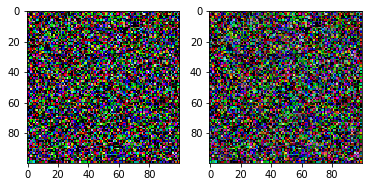

In [3]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt     

class SOMNetwork():
	def __init__(self, input_dim, dim=10, sigma=None, learning_rate=0.1, tay2=1000, dtype=tf.float32):
		if not sigma:
			sigma = dim / 2
		self.dtype = dtype
		#constants
		self.dim = tf.constant(dim, dtype=tf.int64)
		self.learning_rate = tf.constant(learning_rate, dtype=dtype, name='learning_rate')
		self.sigma = tf.constant(sigma, dtype=dtype, name='sigma')
		self.tay1 = tf.constant(1000/np.log(sigma), dtype=dtype, name='tay1')
		self.minsigma = tf.constant(sigma * np.exp(-1000/(1000/np.log(sigma))), dtype=dtype, name='min_sigma')
		self.tay2 = tf.constant(tay2, dtype=dtype, name='tay2')
		#input vector
		self.x = tf.placeholder(shape=[input_dim], dtype=dtype, name='input')
		#iteration number
		self.n = tf.placeholder(dtype=dtype, name='iteration')
		#variables
		self.w = tf.Variable(tf.random_uniform([dim*dim, input_dim], minval=-1, maxval=1, dtype=dtype),
			dtype=dtype, name='weights')
		#helper
		self.positions = tf.where(tf.fill([dim, dim], True))



	def training_op(self):
		win_index = self.__competition('train_')
		with tf.name_scope('cooperation') as scope:
			coop_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(self.positions -
				[win_index//self.dim, win_index-win_index//self.dim*self.dim], 
				dtype=self.dtype)), axis=1))
			sigma = tf.cond(self.n > 1000, lambda: self.minsigma, lambda: self.sigma * tf.exp(-self.n/self.tay1))
			sigma_summary = tf.summary.scalar('Sigma', sigma)
			tnh = tf.exp(-tf.square(coop_dist) / (2 * tf.square(sigma))) # topological neighbourhood
		with tf.name_scope('adaptation') as scope:
			lr = self.learning_rate * tf.exp(-self.n/self.tay2)
			minlr = tf.constant(0.01, dtype=self.dtype, name='min_learning_rate')
			lr = tf.cond(lr <= minlr, lambda: minlr, lambda: lr)
			lr_summary = tf.summary.scalar('Learning rate', lr)
			delta = tf.transpose(lr * tnh * tf.transpose(self.x - self.w))
			training_op = tf.assign(self.w, self.w + delta)
		return training_op, lr_summary, sigma_summary

	def __competition(self, info=''):
		with tf.name_scope(info+'competition') as scope:
			distance = tf.sqrt(tf.reduce_sum(tf.square(self.x - self.w), axis=1))
		return tf.argmin(distance, axis=0)

#== Test SOM Network ==

def test_som_with_color_data():
	som_dim = 100
	som = SOMNetwork(input_dim=3, dim=som_dim, dtype=tf.float64, sigma=3)
	test_data = np.random.uniform(0, 1, (20000, 3))
	training_op, lr_summary, sigma_summary = som.training_op()
	init = tf.global_variables_initializer()
	writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())
	with tf.Session() as sess:
		init.run()
		img1 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
		plt.figure(1)
		plt.subplot(121)
		plt.imshow(img1)
		start = time.time()
		for i, color_data in enumerate(test_data):
			if i % 1000 == 0:
				print('iter:', i)
			sess.run(training_op, feed_dict={som.x: color_data, som.n:i})
		end = time.time()
		print(end - start)
		img2 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
		plt.subplot(122)
		plt.imshow(img2)
	writer.close()
	plt.show()		

test_som_with_color_data()

In [2]:
def Get_Distances(y,x):
    def ring_closure(A):
        if A==1: return [0]
        a=np.arange(A)
        max_val = int(len(a)/2)
        max_ind=np.argwhere(a==max_val)[0,0]
        if len(a)%2==0:
            b=np.arange(1,a[max_ind])[::-1]
        else:
            b=np.arange(1,a[max_ind+1])[::-1]
        a[max_ind+1:]=b
        return a
    yv=ring_closure(y)
    xv=ring_closure(x)
    XV, YV = np.meshgrid(xv, yv)
    #res = np.stack((YV,XV), axis=-1)
    res = np.sqrt(XV**2+YV**2)
    return res

In [5]:
a=np.ones((x*y,5))*np.array([1,2,3,4,5])

In [22]:
x=5
y=1
def _generate_index_matrix(x, y):
        return tf.constant(np.array(list(_iterator(x, y))))
    
def _iterator(x, y):
    for i in range(x):
        for j in range(y):
            yield np.array([i, j])


            
_distance_map = tf.constant(Get_Distances(y,x),dtype='float32')
_locations = _generate_index_matrix(y, x)

# Build a dataflow graph.
_weights  = tf.Variable(a.T,dtype='float32')
_input = 3*tf.constant([1, 1, 1, 1, 1],dtype='float32')
input_matix = tf.stack([_input for i in range(x*y)])
distances = tf.sqrt(tf.reduce_sum((_weights-_input)**2, -1))
bmu = tf.argmin(distances, 0)
bmu_location = _locations[bmu]
_current_learning_rate = tf.maximum(1*tf.exp(-100/1000), 0.1)
_current_radius = 2*tf.exp(-100/1000)

bmu_distance = tf.reshape(tf.roll(_distance_map,shift=bmu_location, axis=[0, 1]),[-1])
neighbourhood_func = tf.exp(-bmu_distance/(2*_current_radius**2))
learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)
 
#Update all the weights
multiplytiplier = tf.stack([tf.tile(tf.slice(learning_rate_matrix, np.array([i]), np.array([1])), [5])
                                               for i in range(x*y)])

delta = tf.transpose(tf.transpose(_input-_weights)*learning_rate_matrix)

# Construct a `Session` to execute the graph.
#sess = tf.Session()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #print(sess.run(distances))
    #print(sess.run(_locations))
    #print(sess.run(bmu))
    print(sess.run(bmu_location))
    #print(sess.run(_distance_map))
    ##print(sess.run(bmu_distance))
    #print(sess.run(neighbourhood_func))
    print(sess.run(learning_rate_matrix))
    #print(sess.run(multiplytiplier))
    print(sess.run(delta))


# Execute the graph and store the value that `e` represents in `result`.
#result = sess.run(bmu_location)
#print(result)


[0 2]
[0.666743  0.77672   0.9048374 0.77672   0.666743 ]
[[ 1.333486  1.333486  1.333486  1.333486  1.333486]
 [ 0.77672   0.77672   0.77672   0.77672   0.77672 ]
 [ 0.        0.        0.        0.        0.      ]
 [-0.77672  -0.77672  -0.77672  -0.77672  -0.77672 ]
 [-1.333486 -1.333486 -1.333486 -1.333486 -1.333486]]


In [23]:
time_start = time()

x = tf.constant(1.0, name='input')
w = tf.Variable(0.8, name='weight')
y = tf.multiply(w, x, name='output')
y_ = tf.constant(0.0, name='correct_value')
loss = tf.pow(y - y_, 2, name='loss')
z = tf.add(y,2, name='JEJE')
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

for value in [z,x, w, y, y_, loss]:
    tf.summary.scalar(value.op.name, value)

summaries = tf.summary.merge_all()

sess = tf.Session()
summary_writer = tf.summary.FileWriter('log_simple_stats', sess.graph)

sess.run(tf.global_variables_initializer())
for i in range(100):
    summary_writer.add_summary(sess.run(summaries), i)
    #print('before step {}, y is {}'.format(i, sess.run(y)))
    #sess.run(y)
    sess.run(train_step)

print(time()-time_start)

29.147895574569702


In [8]:
import numpy
from mayavi.mlab import *

def test_points3d():
    x = DATA[:,0]
    y = DATA[:,1]
    z = DATA[:,2]

    return points3d(x, y, z, colormap="copper", scale_factor=.25)

test_points3d()
show()